# Condensed Nearest Neighbours (CNN)
Machine Learning with Imbalanced Data - Course

The algorithms works as follows:

1. Put all minority class observations in a group, typically group O

2. Add 1 sample (at random) from the majority class to group O

3. Train a KNN with group O

4. Take a sample of the majority class that is not in group O yet

5. Predict its class with the KNN from point 3

6. If the prediction was correct, go to 4 and repeat

7. If the prediction was incorrect, add that sample to group O, go to 3 and repeat

8. Continue until all samples of the majority class were either assigned to O or left out

Final version of Group O is our undersampled dataset

====

* Criteria for data exclusion: Samples outside the boundary between the classes
* Final Dataset size: varies
====

This algorithm tends to pick points near the fuzzy boundary between the classes, and transfer those to the group O, in our example.

If the classes are similar, group O will contain a fair amount of both classes. If the classes are very different, group O would contain mostly 1 class, the minority class.

**Caution**:

* CNN tends to add noise to the undersampled dataset
* Computationally expensive, because it trains 1 KNN every time an observation is added to the minority class group.

In this notebook, we will first understand what Condensed Nearest Neigbours is doing with simulated data, and then compare its effect on model performance with real data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import CondensedNearestNeighbour

## Create data
We will create data where the classes have different degrees of separateness

In [2]:
def make_data(sep):
    # return arrays
    X, y = make_classification(n_samples=1000,
                               n_features=2,
                               n_redundant=0,
                               n_clusters_per_class=1,
                               weights=[0.99],
                               class_sep=sep,   # how separate the classes are
                               random_state=1,)
    
    # transform arrays into pandas df and series
    X = pd.DataFrame(X, columns=['varA', 'varB'])
    y = pd.Series(y)

    return X, y

0    983
1     17
Name: count, dtype: int64


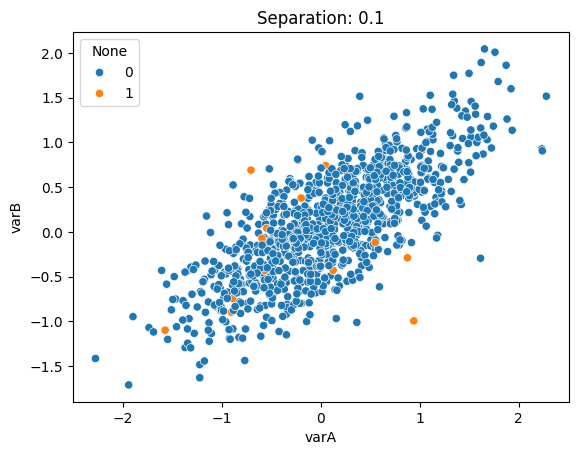

0    983
1     17
Name: count, dtype: int64


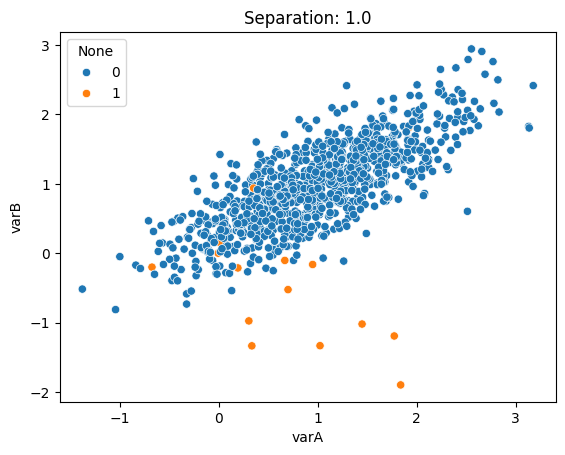

0    983
1     17
Name: count, dtype: int64


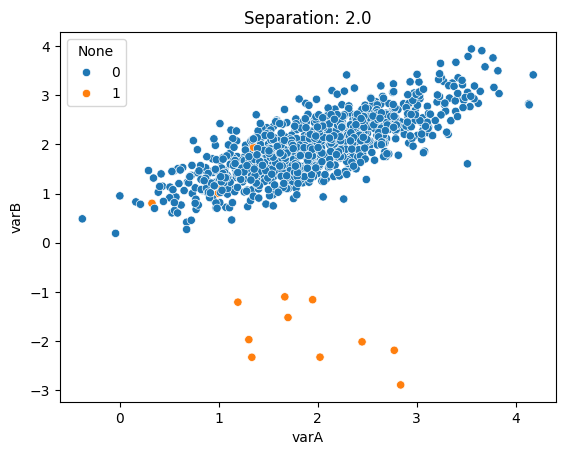

In [3]:
# make datasets with different class separateness
# and plot
for sep in [0.1, 1., 2.]:
    X, y = make_data(sep)
    print(y.value_counts())

    sns.scatterplot(data=X, x='varA', y='varB', hue=y)
    plt.title('Separation: {}'.format(sep))
    plt.show()

As we increase the parameter `sep`, the minority and majority class show less degree of overlap.

## Undersample with Condensed Nearest Neighbours

### Well separated classes

In [4]:
# create data
X, y = make_data(sep=2)

# set up condensed nearest neighbour transformer
cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',
    random_state=0,
    n_neighbors=1,      # default
    n_jobs=4
)

X_resampled, y_resampled = cnn.fit_resample(X, y)

In [5]:
# size of original data
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# size of undersampled data
X_resampled.shape, y_resampled.shape

((70, 2), (70,))

In [7]:
# number of minority class observations
y.value_counts()

0    983
1     17
Name: count, dtype: int64

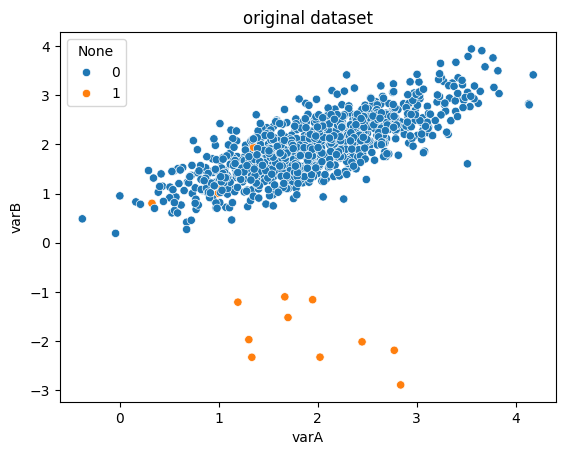

In [8]:
sns.scatterplot(data=X, x='varA', y='varB', hue=y)

plt.title('original dataset')
plt.show()

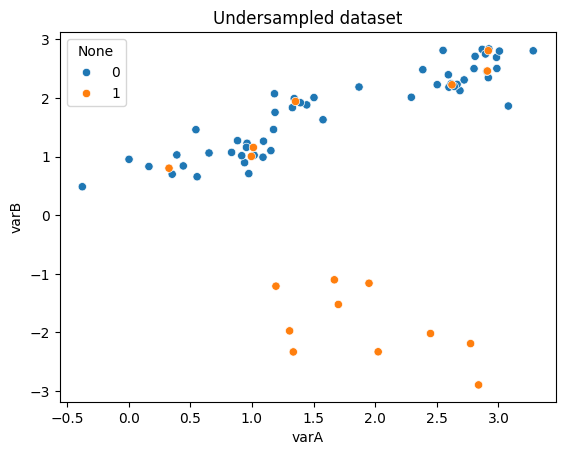

In [9]:
# plot undersampled data
sns.scatterplot(data=X_resampled, x='varA', y='varB', hue=y_resampled)

plt.title('Undersampled dataset')
plt.show()

Condensed Nearest Neighbours retains the observations from the majority class that are more similar to those in the minority class.

Note how values bigger where varA > 3 and varB > 3 have not been included in the undersampled dataset

### Partially separated classes

In [16]:
# create data
X, y = make_data(sep=0.5)

# set up condensed nearest neighbour transformer
cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',
    random_state=0,
    n_neighbors=3,      # changed the number of nearest neighbours
    n_jobs=4
)

X_resampled, y_resampled = cnn.fit_resample(X, y)

In [17]:
# size of original data
X.shape, y.shape

((1000, 2), (1000,))

In [18]:
# size of undersampled data
X_resampled.shape, y_resampled.shape

((64, 2), (64,))

In [19]:
# number of minority class observations
y.value_counts()

0    983
1     17
Name: count, dtype: int64

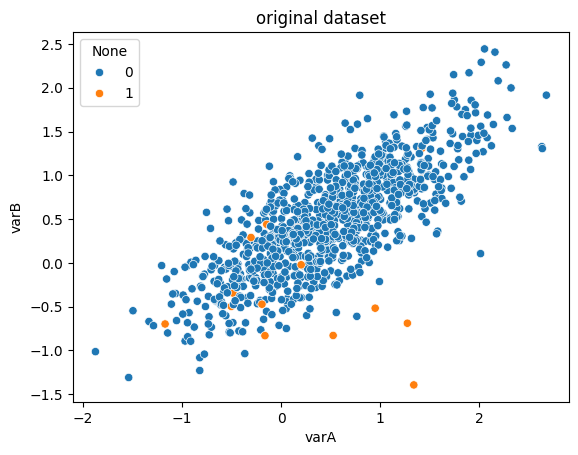

In [20]:
sns.scatterplot(data=X, x='varA', y='varB', hue=y)

plt.title('original dataset')
plt.show()

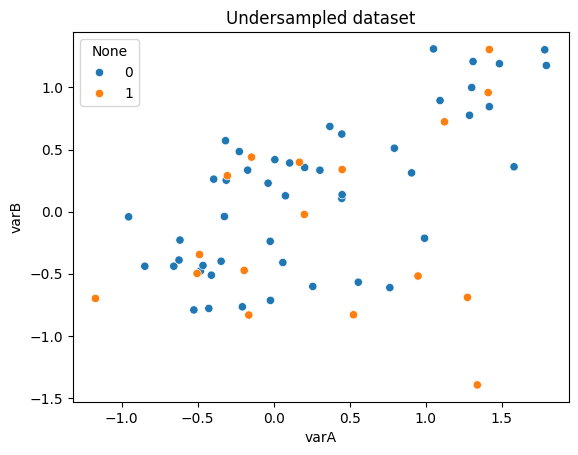

In [21]:
# plot undersampled data
sns.scatterplot(data=X_resampled, x='varA', y='varB', hue=y_resampled)

plt.title('Undersampled dataset')
plt.show()

Note again, how CNN preserves the observations from the majority class that look more similar to those in the minority class.

## Condensed Nearest Neighbours
### Real data - Performance comparison
Does it work well with real datasets?

It will depend on the dataset, so we need to try and compare the models built on the whole dataset, and that built on the undersampled dataset.

In [2]:
# load data
# only a few observations to speed the computation
data = pd.read_csv('../datasets/kdd2004.csv').sample(10000)

data.head()


,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
144673,47.79,32.14,-1.11,-31.0,33.5,1123.8,-0.50,0.10,-1.5,-51.0,...,534.7,1.07,2.58,12.0,-59.0,397.3,0.37,0.16,0.55,-1
49125,55.33,20.35,0.40,-9.0,-15.0,940.2,1.13,-1.12,-8.5,-56.5,...,818.7,1.55,1.89,1.0,-82.0,553.5,1.30,0.13,0.77,-1
86780,55.96,21.77,-1.62,-17.0,12.0,963.3,1.33,0.72,-1.0,-87.5,...,746.3,1.59,-0.66,-19.0,-133.0,284.4,0.96,0.35,0.17,-1
116534,89.14,27.31,-0.56,-40.5,175.5,4890.9,0.38,1.08,28.5,-106.0,...,7202.9,-2.16,1.12,-17.0,-93.0,811.9,1.19,0.09,0.54,-1
136963,60.25,23.04,0.65,50.0,15.0,3817.4,-0.79,-0.67,-2.5,-75.5,...,2960.9,2.10,2.45,-15.0,-103.0,667.6,1.93,0.18,0.88,-1


In [3]:
# imbalanced target
data['target'].value_counts(normalize=True)

target
-1    0.9903
 1    0.0097
Name: proportion, dtype: float64

In [4]:
# separate into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('target', axis=1),
    data['target'],
    test_size=0.3,
    random_state=0
)

X_train.shape, X_test.shape

((7000, 74), (3000, 74))

In [5]:
# set up the undersampler 
cnn = CondensedNearestNeighbour(
    sampling_strategy='auto',
    random_state=0,
    n_neighbors=1,
    n_jobs=-1,
)

X_resampled, y_resampled = cnn.fit_resample(X_train, y_train)

In [6]:
# size of undersampled data
X_resampled.shape, y_resampled.shape

((412, 74), (412,))

In [7]:
# number of positive class in original dataset
y_train.value_counts()

target
-1    6934
 1      66
Name: count, dtype: int64

In [8]:
# number of majority class in undersampled dataset
y_resampled.value_counts()

target
-1    346
 1     66
Name: count, dtype: int64

## Plot data
Let's compare how the data looks before and after the undersampling

Text(0.5, 1.0, 'Original data')

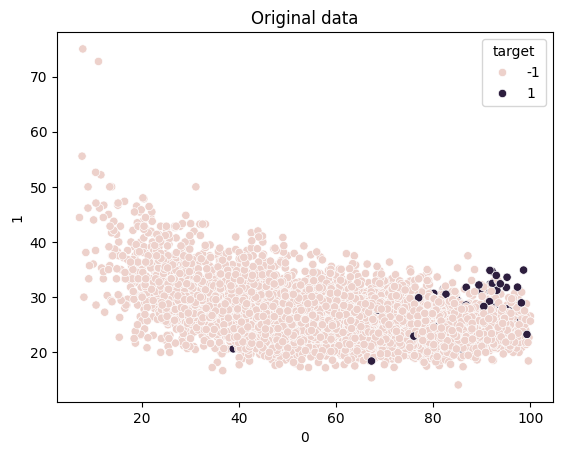

In [9]:
# original data
sns.scatterplot(data=X_train,
                x='0',
                y='1',
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Undersampled data')

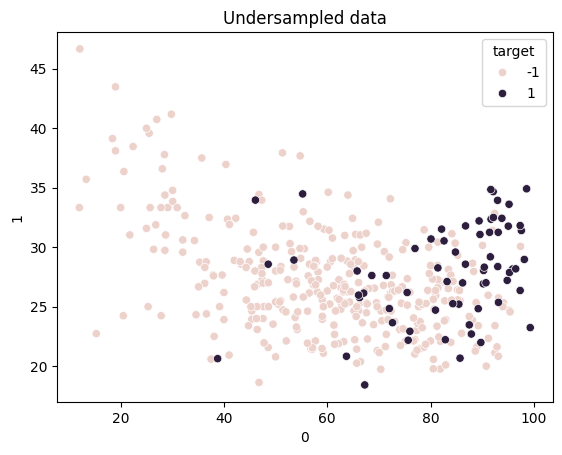

In [10]:
# undersampled data
sns.scatterplot(data=X_resampled,
                x='0',
                y='1',
                hue=y_resampled)

plt.title('Undersampled data')

Text(0.5, 1.0, 'Original data')

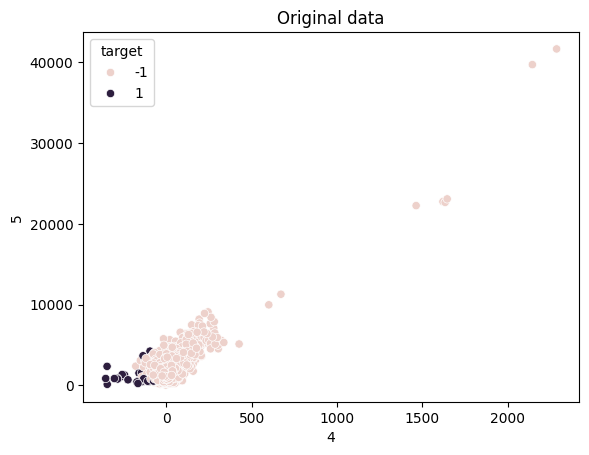

In [11]:
# original data
sns.scatterplot(data=X_train,
                x='4',
                y='5',
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Undersampled data')

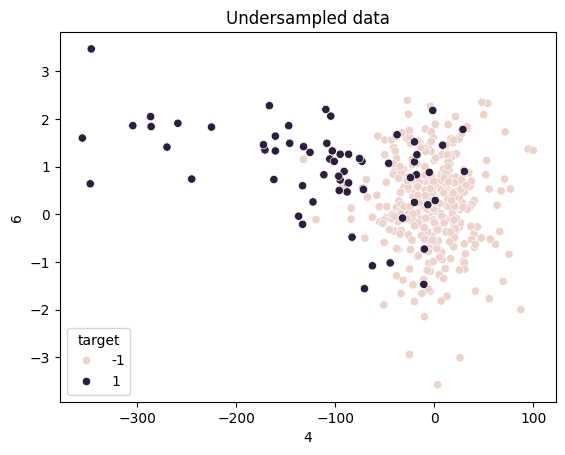

In [12]:
# undersampled data
sns.scatterplot(data=X_resampled,
                x='4',
                y='6',
                hue=y_resampled)

plt.title('Undersampled data')

## Machine learning performance comparison

In [13]:
# function to train random forests and evaluate the performance
def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [14]:
# evaluate performance of algorithm built
# using imbalanced dataset
run_randomForests(X_train, X_test, y_train, y_test)

Train set
Random Forests roc-auc: 0.9971549938380051
Test set
Random Forests roc-auc: 0.9379773791544888


In [15]:
# evaluate performance of algorithm built
# using undersampled dataset
run_randomForests(X_resampled, X_test, y_resampled, y_test)

Train set
Random Forests roc-auc: 0.9983797512699247
Test set
Random Forests roc-auc: 0.9583926379034975
